In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pygad
import logging
import random
import seaborn as sns


In [2]:
arr = pd.read_csv("phylo.csv",
                 delimiter=",")
display(arr)

,Unnamed: 0,Phylostratum,GeneID,Zygote,Quadrant,Globular,Heart,Torpedo,Bent,Mature
0,1,1,at1g01040.2,2173.635205,1911.200145,1152.555283,1291.422445,1000.252931,962.977223,1696.427421
1,2,1,at1g01050.1,1501.014084,1817.308557,1665.308874,1564.761244,1496.320663,1114.643547,1071.655487
2,3,1,at1g01070.1,1212.792724,1233.002267,939.200046,929.619501,864.218009,877.206001,894.818917
3,4,1,at1g01080.2,1016.920321,936.383717,1181.338144,1329.473434,1392.642854,1287.974590,861.260488
4,5,1,at1g01090.1,11424.566680,16778.168460,34366.649350,39775.640530,56231.568920,66980.367330,7772.561656
...,...,...,...,...,...,...,...,...,...,...
25255,25256,12,at5g67200.1,721.139701,731.211686,788.833156,815.185775,871.509726,809.404700,749.102579
25256,25257,12,at5g67245.1,1132.810160,1145.611552,1030.842523,1142.514730,1175.351616,985.904374,1147.261206
25257,25258,12,at5g67280.1,731.678348,748.688731,705.033813,622.710117,730.698691,864.307779,774.050852
25258,25259,12,at5g67380.1,14725.097780,2426.968469,2463.236828,2395.512964,1847.669032,1943.984418,5137.928045


In [3]:
ex_data = arr[["Zygote", "Quadrant","Globular","Heart","Torpedo","Bent","Mature"]]


In [4]:
var_ex = ex_data.var(axis=1)/ex_data.mean(axis=1) 
age_weighted = ex_data.mul(arr["Phylostratum"], axis=0)
perc = 1
high_var_ind =  np.argsort(var_ex)[-round(len(var_ex) * perc):]
low_var_ind =  np.argsort(var_ex)[:-round(len(var_ex) * perc)]


In [5]:
high_var_w = age_weighted.iloc[high_var_ind,:]
high_var = ex_data.iloc[high_var_ind,:]
low_var_w = age_weighted.iloc[low_var_ind,:]
low_var = ex_data.iloc[low_var_ind,:]

high_var_w_n = high_var_w.to_numpy()
high_var_n = high_var.to_numpy()

In [6]:
display(high_var.index.values)

array([ 6286, 20893, 19993, ..., 17229,  4611, 21272])

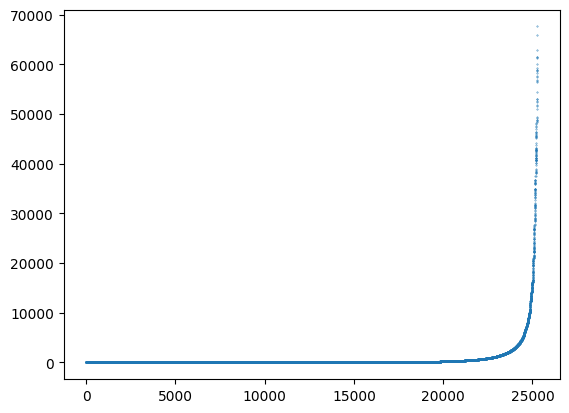

In [7]:
plt.scatter(range(len(var_ex)),sorted(var_ex),s=0.1)

In [8]:
low_var_w_sum = low_var_w.sum(axis=0).to_numpy()
low_var_sum = low_var.sum(axis=0).to_numpy()

len_low_var =low_var.shape[0]

In [9]:
max_removed = 5000

In [10]:
def fitness_batch(ga_instance, solution, solution_idx):
    up = np.add(solution.dot(high_var_w_n),np.tile(low_var_w_sum,(solution.shape[0],1)))
    down = np.add(np.tile(low_var_sum,(solution.shape[0],1)), solution.dot(high_var_n))
    avgs = np.divide(up,down)
    num_not_removed = np.sum(solution,axis = 1)
    return - np.var(avgs,axis=1) + (num_not_removed/solution.shape[1]**2*1.e0)
            
    

In [11]:
def fitness(ga_instance, solution, solution_idx):
    up = np.add(high_var_w.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy(),low_var_w_sum)
    down = np.add(low_var_sum, high_var.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy())
    avgs = np.divide(up,down)
    
    return - np.var(avgs) + ((sum(solution)/len(solution))**2)*1.e-1
    

In [12]:
def print_curve(solution,label=None):
    up = np.add(high_var_w.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy(),low_var_w_sum)
    down = np.add(low_var_sum, high_var.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy())
    avgs = np.divide(up,down)
    print(np.var(avgs))
    plt.ylim(3, 3.8)
    plt.plot(list(range(7)),avgs,'-o',label=label)
    if label:
        plt.legend()
    

In [13]:
def create_population(size):
    return np.array([random.choices([0,1], weights=(1, 30), k=high_var.shape[0]) for _  in range(size)])

In [14]:
pop = create_population(5)
np.sum(pop,axis = 1)

array([24461, 24447, 24469, 24493, 24435])

0.009837646583158657


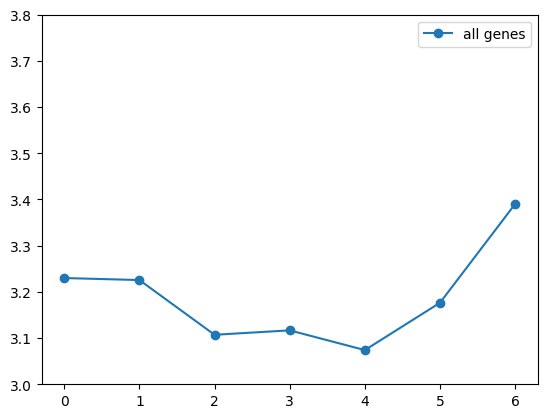

In [15]:
print_curve(np.ones(high_var.shape[0]), label="all genes")

In [58]:
level = logging.DEBUG
name = 'logfile.txt'

logger = logging.getLogger(name)
logger.setLevel(level)


console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_format = logging.Formatter('%(message)s')
console_handler.setFormatter(console_format)
logger.addHandler(console_handler)

num_threads = 5
population = create_population(90)

ga_instance = pygad.GA(num_generations=150,
                       num_parents_mating=20,
                       fitness_func=fitness_batch,
                       fitness_batch_size=population.shape[0],
                       initial_population=population,
                       crossover_probability=0.1,
                       mutation_probability=0.0005,
                       init_range_low=0,
                       init_range_high=2,
                       gene_type=int,
                       crossover_type="uniform",
                       parallel_processing=["thread", num_threads],
                       save_best_solutions=True,
                       keep_elitism=1,
                       save_solutions=True
                       )

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()

/usr/local/lib/python3.10/site-packages/pygad/pygad.py:1074: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")
/usr/local/lib/python3.10/site-packages/pygad/pygad.py:1083: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


2.2771213749274746e-05
1727
0.06836896278701504


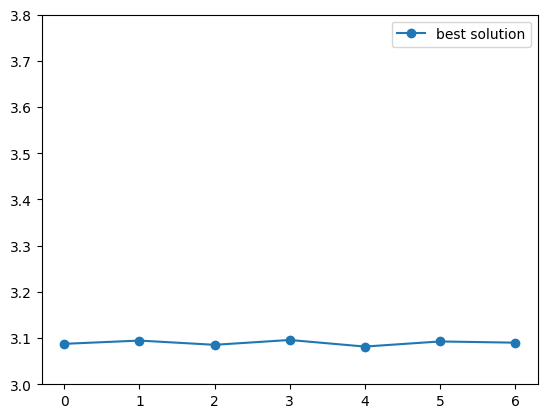

In [59]:
print_curve(solution,label="best solution")
print(len(np.where(solution == 0)[0]))
print(len(np.where(solution == 0)[0])/len(solution))


In [57]:
print(len(set(ga_instance.best_solutions_fitness))/population.shape[0])

print(len(set(ga_instance.best_solutions_fitness)))

1.18
118


1.4110458349416502e-05


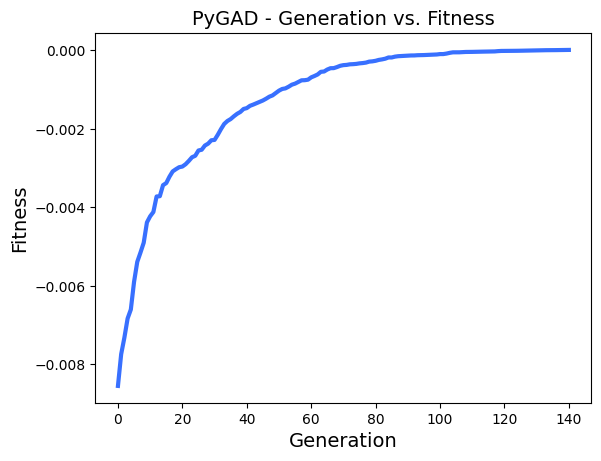

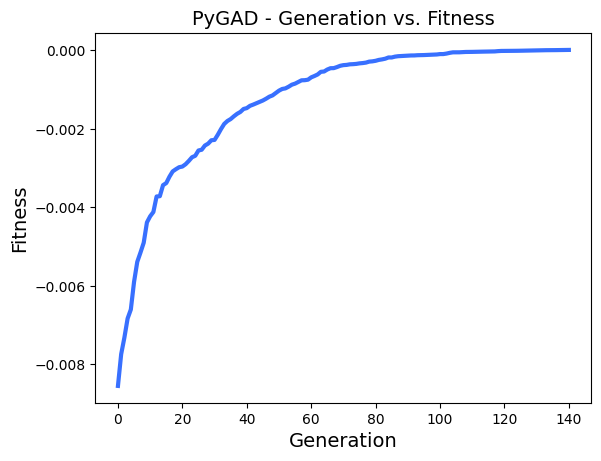

In [177]:
print(solution_fitness)
ga_instance.plot_fitness()

In [61]:

lens = len(solution) - np.sum(np.array(ga_instance.solutions),axis = 1)
fit =fitness_batch(None,np.array(ga_instance.solutions),None)
fit_ind = np.argsort(fitness_batch(None,np.array(ga_instance.solutions),None))
plt.scatter(lens,fit, s=0.1)

KeyboardInterrupt: 

In [178]:
ga_instance.plot_new_solution_rate()

0.006025097320041596


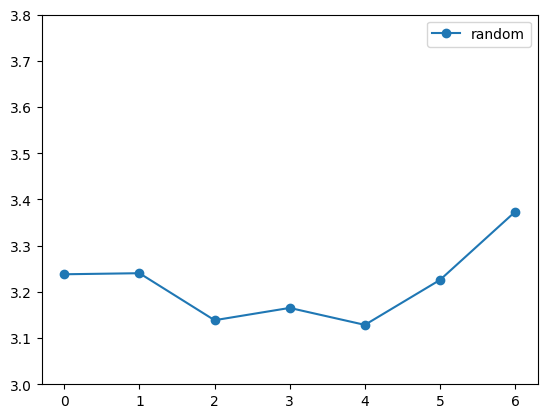

In [76]:
print_curve(np.random.randint(0,2, size=high_var.shape[0]),label="random")

0.009837646583158657


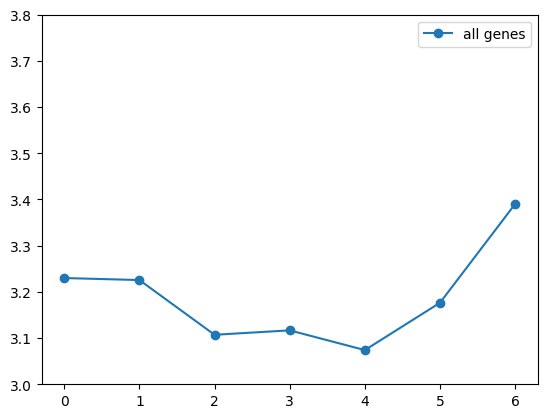

In [532]:
print_curve(np.ones(high_var.shape[0]), label="all genes")

In [66]:
removed_genes =  arr.iloc[high_var.index.values[np.where(solution == 0)[0]],:]#["GeneID","Phylostratum"]
display(removed_genes)

,Unnamed: 0,Phylostratum,GeneID,Zygote,Quadrant,Globular,Heart,Torpedo,Bent,Mature
13890,13891,2,at4g34430.4,650.749754,641.870893,657.987142,640.918414,639.963682,651.763154,664.769432
13538,13539,2,at4g20330.1,756.942191,734.968451,733.061815,748.369581,741.393580,717.904332,736.007027
22952,22953,10,at4g01735.1,913.518530,921.247869,914.406365,928.995043,935.153958,957.353891,917.155100
7679,7680,1,at5g20260.1,767.675661,773.242717,805.095382,769.106894,790.930089,796.513188,783.468217
17865,17866,4,at3g49840.1,719.729517,703.287719,691.129790,718.362982,703.231054,681.728832,709.361667
...,...,...,...,...,...,...,...,...,...,...
21826,21827,8,at2g42560.1,2457.993370,835.481543,834.124473,760.883619,726.684578,3752.426116,68490.545990
23539,23540,12,at1g07500.1,2236.167648,872.144043,816.071814,852.034298,824.409176,1904.961405,67841.771130
20470,20471,6,at2g42000.2,1222.490371,965.358396,818.341208,932.676571,985.740730,2320.772865,68712.003370
21446,21447,7,at1g07985.1,2962.440546,904.682744,899.162118,814.911574,784.399822,2371.147397,71635.640930


<AxesSubplot: xlabel='Phylostratum', ylabel='Count'>

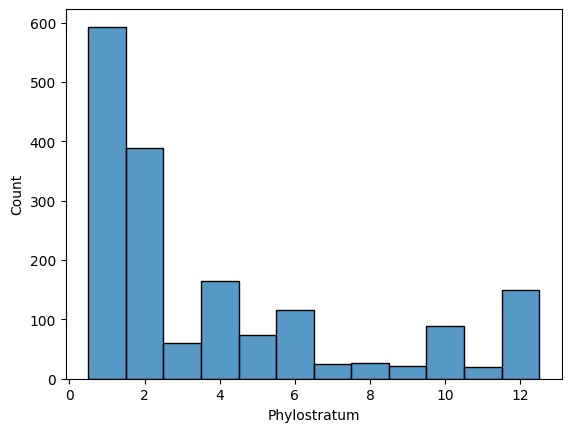

In [71]:
sns.histplot(data=removed_genes, x="Phylostratum",discrete=True)

In [165]:
variances_df = pd.DataFrame(data={'removed': variances, 'removed_cv': variances/removed_genes.iloc[:, 2:].mean(axis=1),'all': ex_data.var(axis=1),'all_cv': ex_data.var(axis=1)/ex_data.mean(axis=1)})


/var/folders/pw/r8s9dk9x4z56sfjh5qm3t8gw0002n8/T/ipykernel_46436/3744421545.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variances_df = pd.DataFrame(data={'removed': variances, 'removed_cv': variances/removed_genes.iloc[:, 2:].mean(axis=1),'all': ex_data.var(axis=1),'all_cv': ex_data.var(axis=1)/ex_data.mean(axis=1)})


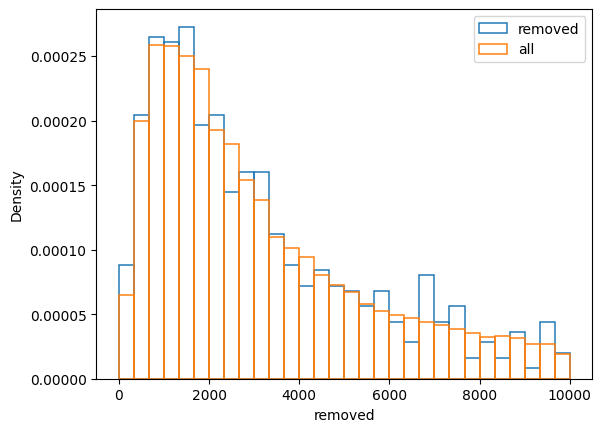

In [175]:
sns.histplot(data=variances_df,x="removed",stat="density",binrange=(0,10000),fill=False,common_norm=False,bins=30,label="removed")
sns.histplot(data=variances_df,x="all",stat="density",binrange=(0,10000),fill=False,common_norm=False,bins=30,label="all")
plt.legend()


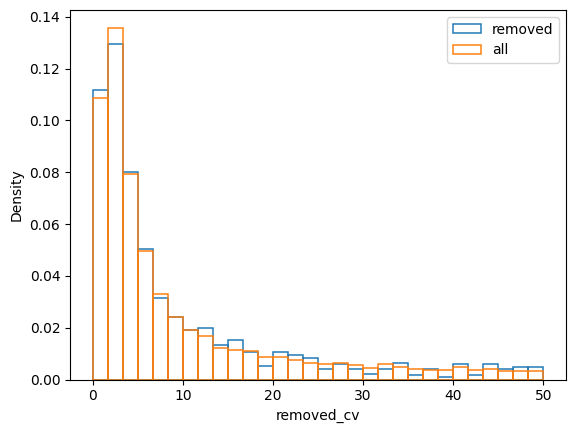

In [176]:
sns.histplot(data=variances_df,x="removed_cv",stat="density",binrange=(0,50),fill=False,common_norm=False,bins=30,label="removed")
sns.histplot(data=variances_df,x="all_cv",stat="density",binrange=(0,50),fill=False,common_norm=False,bins=30,label="all")
plt.legend()
